In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
data = Path.cwd().parent / 'data'
df = pd.read_csv(data / 'limpo_solicitacoes_doc9.csv',
    parse_dates=[
        'datahora_abertura_solicitacao',
        'datahora_finalizacao_solicitacao',
        'datahora_audiencia',
        'prazo_para_inserir_dados',
        ]
    )
df = df.drop(columns=['Unnamed: 0'])

# Jurídico
_Pergunta do stakeholder:_

_“Em quais áreas do direito ocorrem mais problemas? É mais comum em trabalhista ou cível? Existe relação com a antecedência com que o cliente envia os dados?”_

In [3]:
df_probs_area = (
    df
    .groupby(['area_processo'])
    [['houve_revelia', 'houve_ausencia', 'houve_ma_atuacao']]
    .sum()
)

df_probs_area['houve_qualquer_problema'] = df_probs_area.apply(lambda x: sum(x), axis=1)

df_probs_area['qtd_processos_total'] = (
    df
    .groupby(['area_processo'])
    ['id_solicitacao']
    .count()
)

df_probs_area['qtd_problema_norml'] = (
    df_probs_area
    .apply(
        lambda x: (x['houve_qualquer_problema'] / x['qtd_processos_total']) * 100,
        axis=1)
    )

df_probs_area.reset_index(inplace=True)
df_probs_area

,area_processo,houve_revelia,houve_ausencia,houve_ma_atuacao,houve_qualquer_problema,qtd_processos_total,qtd_problema_norml
0,Cível,25,284,18,327,18108,1.805832
1,Penal,0,0,0,0,4,0.000000
2,Trabalhista,7,114,44,165,11886,1.388188


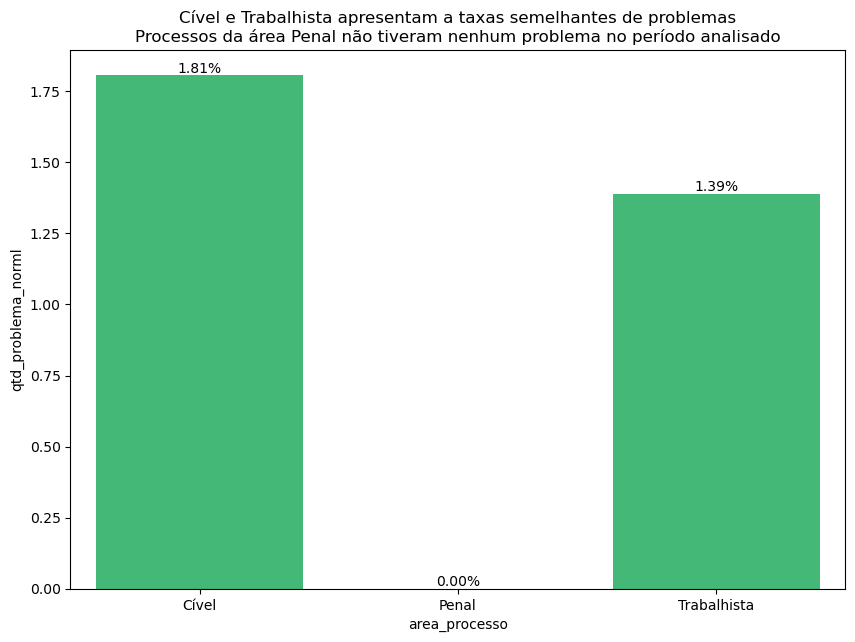

In [4]:
plt.figure(figsize=(10, 7))

probs_plt = (
    sns.barplot(
        data = df_probs_area,
        x='area_processo',
        y='qtd_problema_norml',
        orient='v',
        color='#31cb74'
        )

)

for container in probs_plt.containers:
    bar_values = [bar.get_width() for bar in container]
    probs_plt.bar_label(
        container,
        fmt='{:.2f}%',
        color='black',
        padding=0,
        label_type='edge'
        )

plt.title(
     'Cível e Trabalhista apresentam a taxas semelhantes de problemas\n' + \
    'Processos da área Penal não tiveram nenhum problema no período analisado'
    );

_Existe relação com a antecedência com que o cliente envia os dados?_

Como são duas variáveis categóricas nominais, o Teste Chi Quadrado é útil para determinar a correlação entre as áreas de atuação e a tempestividade das informações prestadas pelo cliente.

In [5]:
from scipy.stats import chi2_contingency

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

In [6]:
chi2, pvalue, dof, expected_freq = chi2_contingency(pd.crosstab(df['area_processo'], df['situacao_dados']))

print('-' * 20)
print(f"Estatística Qui-Quadrado: {chi2}")
# Mede a discrepância entre as frequências observadas
# e as frequências esperadas sob a hipótese de independência.
print(f"Valor p: {pvalue}")
# A probabilidade de observar os dados (ou dados mais extremos) se a hipótese nula fosse verdadeira.
# Um valor p baixo (geralmente ≤0.05) sugere que há evidências suficientes para rejeitar a
# hipótese nula e concluir que há uma associação entre as variáveis.
print(f"Graus de Liberdade: {dof}")
# O número de valores na estatística final que são livres para variar.

--------------------
Estatística Qui-Quadrado: 219.90485709220565
Valor p: 1.7711975816744877e-48
Graus de Liberdade: 2


## V de Cramér

0 $\rightarrow$ nenhuma associação.

1 $\rightarrow$ associação perfeita.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

In [7]:
from scipy.stats.contingency import association

In [8]:
association(
    pd.crosstab(df['area_processo'], df['situacao_dados']),
    method='cramer'
)

0.0856192187135248

Presumindo que a base de dados analisada é uma representação fiel dos eventos ocorridos durante o período analisado, de acordo com testes de Chi Quadrado e V de Cramér, os problemas encontrados nas diferentes searas de atuação tem pouca relação com o périodo em que o cliente envia dos dados para os parceiros.